In [1]:
import pathlib
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("PROJECT_DIR", PROJECT_DIR := pathlib.Path.cwd().parent)
print("DATA_DIR", DATA_DIR := PROJECT_DIR / "data")


/home/uzunb/Projects/municipality-bus-utilization-forecasting/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting
DATA_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting/data


In [3]:
# Read the data
df = pd.read_csv(DATA_DIR / 'municipality_bus_utilization.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('timestamp')
df

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-04 07:59:42,9,454,1332
2017-06-04 07:59:42,8,556,2947
2017-06-04 07:59:42,4,1090,3893
2017-06-04 07:59:42,0,204,2813
2017-06-04 07:59:42,7,718,2019
...,...,...,...
2017-08-19 16:30:35,2,548,697
2017-08-19 16:30:35,8,1193,2947
2017-08-19 16:30:35,7,1354,2019


In [4]:
selected_municipality_id = 4
df = df[df['municipality_id'] == selected_municipality_id]
df.drop(columns=['municipality_id'], inplace=True)
df

/tmp/ipykernel_334048/881798794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['municipality_id'], inplace=True)


,usage,total_capacity
timestamp,,
2017-06-04 07:59:42,1090,3893
2017-06-04 08:25:42,1476,3893
2017-06-04 08:59:42,2016,3893
2017-06-04 09:32:46,2511,3893
2017-06-04 09:59:48,2811,3893
...,...,...
2017-08-19 14:30:33,3176,3893
2017-08-19 15:03:34,3111,3893
2017-08-19 15:29:33,2980,3893


In [5]:
# split timestamp to year, month, day and hour, minute, second
df['date'] = pd.to_datetime(df.index.date)
df['time'] = df.index.time
df['year'] = df.index.year
df['month'] = df.index.month
df['dayOfWeek'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['second'] = df.index.second
df['quarter'] = df.index.quarter
df['dayOfYear'] = df.index.dayofyear

df.head()

/tmp/ipykernel_334048/3626342785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.index.date)
/tmp/ipykernel_334048/3626342785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df.index.time
/tmp/ipykernel_334048/3626342785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear
timestamp,,,,,,,,,,,,,
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25,42,2,155
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59,42,2,155
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32,46,2,155
2017-06-04 09:59:48,2811,3893,2017-06-04,09:59:48,2017,6,6,4,9,59,48,2,155


In [6]:
df['usage_percentage'] = df['usage']/df['total_capacity']*100
df.sort_values(by='usage_percentage', ascending=False).head()

/tmp/ipykernel_334048/1456185888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usage_percentage'] = df['usage']/df['total_capacity']*100


,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-08-13 12:02:55,3508,3893,2017-08-13,12:02:55,2017,8,6,13,12,2,55,3,225,90.110455
2017-07-29 12:28:36,3507,3893,2017-07-29,12:28:36,2017,7,5,29,12,28,36,3,210,90.084768
2017-07-29 13:02:35,3505,3893,2017-07-29,13:02:35,2017,7,5,29,13,2,35,3,210,90.033393
2017-07-30 13:28:41,3504,3893,2017-07-30,13:28:41,2017,7,6,30,13,28,41,3,211,90.007706
2017-07-29 11:55:30,3502,3893,2017-07-29,11:55:30,2017,7,5,29,11,55,30,3,210,89.956332


In [7]:
# edit usage data for total capacity
df['usage'] = df.apply(lambda x: x['total_capacity'] if x['usage'] > x['total_capacity'] else x['usage'], axis=1)
df['usage_percentage'] = df['usage']/df['total_capacity']*100
df.sort_values(by='usage_percentage', ascending=False).head()

/tmp/ipykernel_334048/2968959823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usage'] = df.apply(lambda x: x['total_capacity'] if x['usage'] > x['total_capacity'] else x['usage'], axis=1)
/tmp/ipykernel_334048/2968959823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usage_percentage'] = df['usage']/df['total_capacity']*100


,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-08-13 12:02:55,3508,3893,2017-08-13,12:02:55,2017,8,6,13,12,2,55,3,225,90.110455
2017-07-29 12:28:36,3507,3893,2017-07-29,12:28:36,2017,7,5,29,12,28,36,3,210,90.084768
2017-07-29 13:02:35,3505,3893,2017-07-29,13:02:35,2017,7,5,29,13,2,35,3,210,90.033393
2017-07-30 13:28:41,3504,3893,2017-07-30,13:28:41,2017,7,6,30,13,28,41,3,211,90.007706
2017-07-29 11:55:30,3502,3893,2017-07-29,11:55:30,2017,7,5,29,11,55,30,3,210,89.956332


In [8]:
# Check missing values. due to 'There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.'

check_df = df[['date', 'hour']].groupby(['date', 'hour']).size().reset_index(name='counts')
print("Count of one measurement for an hour", check_df[check_df['counts'] == 1].shape[0])
print("Count of two measurements for an hour", check_df[check_df['counts'] == 2].shape[0])
print("Count of more than two measurements for an hour", check_df[check_df['counts'] > 2].shape[0])
check_df.sort_values('counts', ascending=True)

Count of one measurement for an hour 136
Count of two measurements for an hour 451
Count of more than two measurements for an hour 87


,date,hour,counts
0,2017-06-04,7,1
583,2017-08-10,10,1
581,2017-08-10,8,1
580,2017-08-10,7,1
301,2017-07-08,7,1
...,...,...,...
228,2017-06-30,8,4
231,2017-06-30,11,4
235,2017-06-30,15,4
229,2017-06-30,9,4


In [9]:
# create new timestamp for one measurement for an hour
from datetime import datetime


new_timestamps = pd.DataFrame(columns=['timestamp', 'usage', 'total_capacity', 'date', 'time', 'year', 'month', 'dayOfWeek', 'day', 'hour'])
for date in df['date'].unique():
    for hour in df['hour'].unique():
        if check_df[(check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
            date = pd.to_datetime(date)
            new_record = {'timestamp': f"{date} {hour}:00:00", 'usage': np.nan, 'total_capacity': np.nan,
                            'date': date, 'time': datetime.strptime(f"{hour}:00:00", '%H:%M:%S').time(), 'year': date.year, 'month': date.month, 'dayOfWeek': date.dayofweek, 'day': date.day, 'hour': hour,
                            'minute': 0, 'second': 0, 'quarter': date.quarter, 'dayOfYear': date.dayofyear, 'usage_percentage': np.nan}
            new_timestamps = pd.concat(
                [new_timestamps, pd.DataFrame.from_records([new_record])])

# add new timestamp to df
expanded_df = df.copy()
expanded_df = expanded_df.reset_index()
expanded_df = pd.concat([expanded_df, new_timestamps], ignore_index=True)
expanded_df['timestamp'] = pd.to_datetime(expanded_df['timestamp'])
expanded_df = expanded_df.set_index('timestamp')
expanded_df.sort_index(inplace=True)
expanded_df


/tmp/ipykernel_334048/2152791479.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_df[(check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
/tmp/ipykernel_334048/2152791479.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_df[(check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
/tmp/ipykernel_334048/2152791479.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_df[(check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
/tmp/ipykernel_334048/2152791479.py:8: D

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-06-04 07:00:00,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59.0,42.0,2.0,155.0,27.998973
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25.0,42.0,2.0,155.0,37.914205
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59.0,42.0,2.0,155.0,51.785256
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32.0,46.0,2.0,155.0,64.500385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-19 14:30:33,3176,3893,2017-08-19,14:30:33,2017,8,5,19,14,30.0,33.0,3.0,231.0,81.582327
2017-08-19 15:03:34,3111,3893,2017-08-19,15:03:34,2017,8,5,19,15,3.0,34.0,3.0,231.0,79.912664
2017-08-19 15:29:33,2980,3893,2017-08-19,15:29:33,2017,8,5,19,15,29.0,33.0,3.0,231.0,76.547650


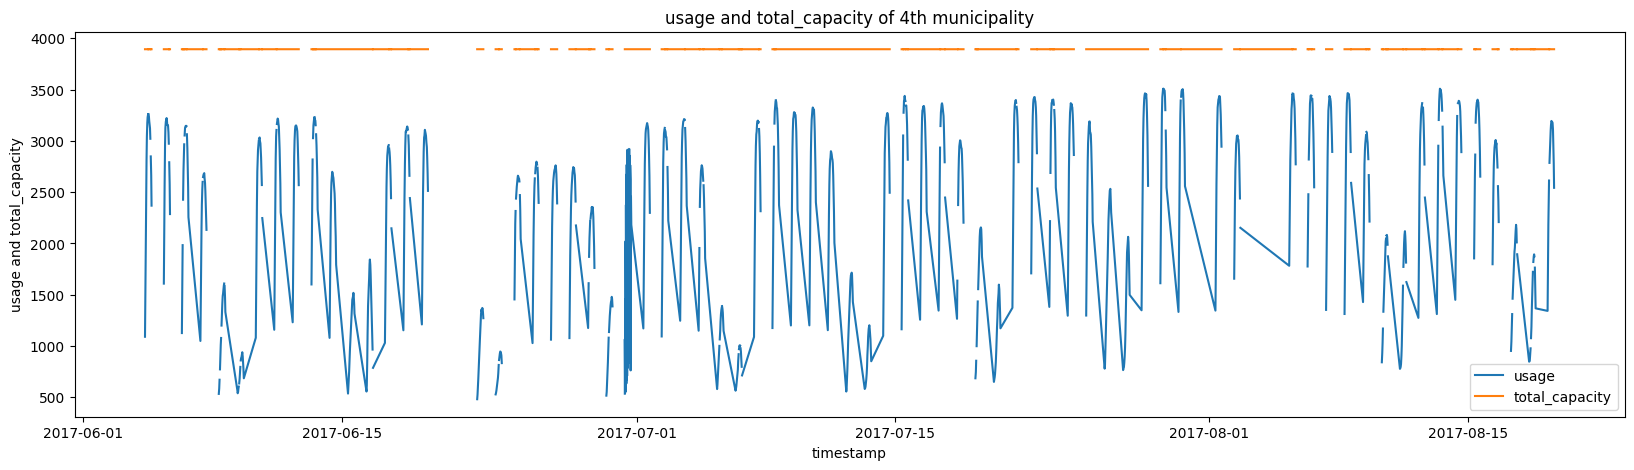

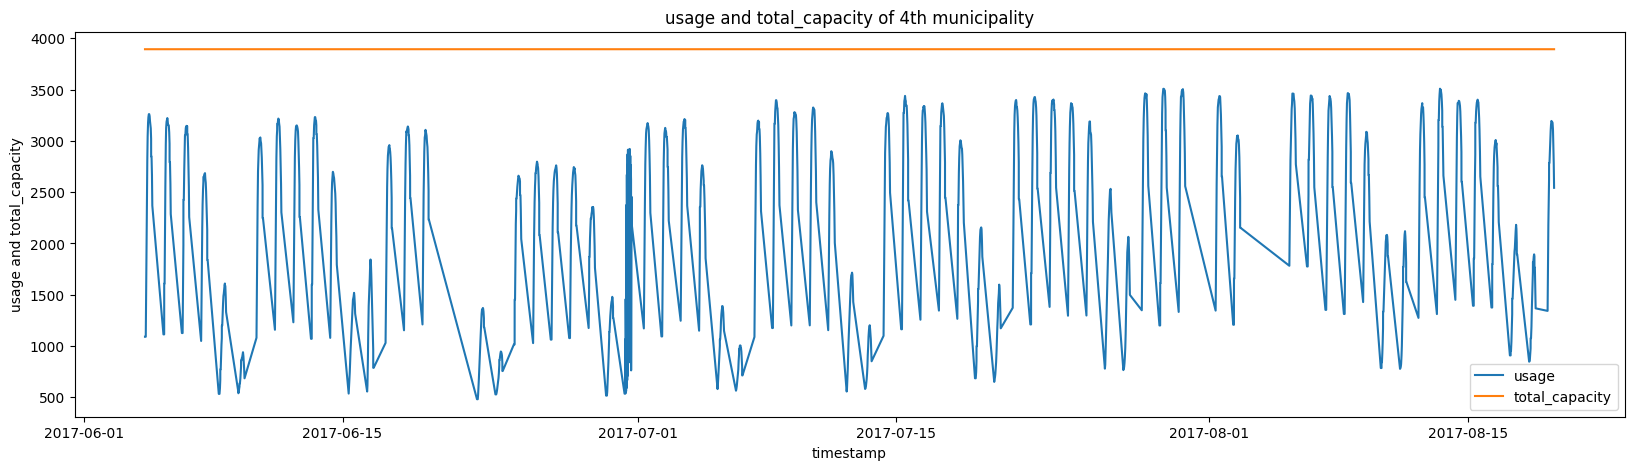

In [10]:
# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(expanded_df['usage'], label='usage')
ax.plot(expanded_df['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()

# impute missing values for each municipality
imputed_df = expanded_df.copy()

# fill total_capacity with max value
imputed_df['total_capacity'] = imputed_df['total_capacity'].fillna(imputed_df['total_capacity'].max())

# fill usage with interpolation that is best appropriate of method
imputed_df['usage'] = imputed_df['usage'].fillna(method='bfill')
imputed_df['usage'] = imputed_df['usage'].fillna(method='ffill')

imputed_df['usage_percentage'] = imputed_df['usage']/imputed_df['total_capacity']*100

# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(imputed_df['usage'], label='usage')
ax.plot(imputed_df['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()



In [11]:
df = imputed_df.copy()

# Preprocessing

In [12]:
FEATURES = df.drop(columns=['usage', 'time']).columns
TARGET = 'usage'

# split data to train and test set
horizon = pd.to_datetime("2017-08-05")

train = df[df.date < horizon]
test = df[df.date >= horizon]

print(f"Shape of Dataframe: {df.shape}")
print(f"Shape of Train Set: {train.shape}")
print(f"Shape of Test Set: {test.shape}")

Shape of Dataframe: (1443, 14)
Shape of Train Set: (1138, 14)
Shape of Test Set: (305, 14)


# Model Development

## Forecasting with Prophet

In [13]:
train.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1138 entries, 2017-06-04 07:00:00 to 2017-08-02 16:32:54
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   usage             1138 non-null   int64         
 1   total_capacity    1138 non-null   int64         
 2   date              1138 non-null   datetime64[ns]
 3   time              1138 non-null   object        
 4   year              1138 non-null   object        
 5   month             1138 non-null   object        
 6   dayOfWeek         1138 non-null   object        
 7   day               1138 non-null   object        
 8   hour              1138 non-null   object        
 9   minute            1138 non-null   float64       
 10  second            1138 non-null   float64       
 11  quarter           1138 non-null   float64       
 12  dayOfYear         1138 non-null   float64       
 13  usage_percentage  1138 non-null   float64 

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-06-04 07:00:00,1090,3893,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,27.998973
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59.0,42.0,2.0,155.0,27.998973
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25.0,42.0,2.0,155.0,37.914205
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59.0,42.0,2.0,155.0,51.785256
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32.0,46.0,2.0,155.0,64.500385


In [14]:
# prepare data for training
train = train.reset_index()
train['ds'] = train['timestamp']
train['y'] = train['usage']

test = test.reset_index()
test['ds'] = test['timestamp']
test['y'] = test['usage']

# change data type of columns
train['total_capacity'] = train['total_capacity'].astype('int')
train['usage_percentage'] = train['usage_percentage'].astype('float64')
train['y'] = train['y'].astype('int')

test['total_capacity'] = test['total_capacity'].astype('int')
test['usage_percentage'] = test['usage_percentage'].astype('float64')
test['y'] = test['y'].astype('int')

train.drop(columns=['timestamp'], inplace=True)
train.drop(columns=['usage'], inplace=True)
train.drop(columns=['time'], inplace=True)
test.drop(columns=['timestamp'], inplace=True)
test.drop(columns=['usage'], inplace=True)
test.drop(columns=['time'], inplace=True)

print(train.info())
display(train.head())
display(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   total_capacity    1138 non-null   int64         
 1   date              1138 non-null   datetime64[ns]
 2   year              1138 non-null   object        
 3   month             1138 non-null   object        
 4   dayOfWeek         1138 non-null   object        
 5   day               1138 non-null   object        
 6   hour              1138 non-null   object        
 7   minute            1138 non-null   float64       
 8   second            1138 non-null   float64       
 9   quarter           1138 non-null   float64       
 10  dayOfYear         1138 non-null   float64       
 11  usage_percentage  1138 non-null   float64       
 12  ds                1138 non-null   datetime64[ns]
 13  y                 1138 non-null   int64         
dtypes: datetime64[ns](2), fl

,total_capacity,date,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage,ds,y
0,3893,2017-06-04,2017,6,6,4,7,0.0,0.0,2.0,155.0,27.998973,2017-06-04 07:00:00,1090
1,3893,2017-06-04,2017,6,6,4,7,59.0,42.0,2.0,155.0,27.998973,2017-06-04 07:59:42,1090
2,3893,2017-06-04,2017,6,6,4,8,25.0,42.0,2.0,155.0,37.914205,2017-06-04 08:25:42,1476
3,3893,2017-06-04,2017,6,6,4,8,59.0,42.0,2.0,155.0,51.785256,2017-06-04 08:59:42,2016
4,3893,2017-06-04,2017,6,6,4,9,32.0,46.0,2.0,155.0,64.500385,2017-06-04 09:32:46,2511


,total_capacity,date,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage,ds,y
0,3893,2017-08-05,2017,8,5,5,8,2.0,3.0,3.0,217.0,45.774467,2017-08-05 08:02:03,1782
1,3893,2017-08-05,2017,8,5,5,8,29.0,8.0,3.0,217.0,54.764963,2017-08-05 08:29:08,2132
2,3893,2017-08-05,2017,8,5,5,9,2.0,8.0,3.0,217.0,65.707680,2017-08-05 09:02:08,2558
3,3893,2017-08-05,2017,8,5,5,9,29.0,8.0,3.0,217.0,72.283586,2017-08-05 09:29:08,2814
4,3893,2017-08-05,2017,8,5,5,10,3.0,4.0,3.0,217.0,77.343951,2017-08-05 10:03:04,3011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,3893,2017-08-19,2017,8,5,19,14,30.0,33.0,3.0,231.0,81.582327,2017-08-19 14:30:33,3176
301,3893,2017-08-19,2017,8,5,19,15,3.0,34.0,3.0,231.0,79.912664,2017-08-19 15:03:34,3111
302,3893,2017-08-19,2017,8,5,19,15,29.0,33.0,3.0,231.0,76.547650,2017-08-19 15:29:33,2980
303,3893,2017-08-19,2017,8,5,19,16,3.0,35.0,3.0,231.0,71.384536,2017-08-19 16:03:35,2779


In [15]:
model = Prophet()

# add regressors
for feature in FEATURES:
    model.add_regressor(feature)

# fit model
model.fit(train)

18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:31 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=test.shape[0])
future = future.merge(test, on='ds', how='right')
forecast = model.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# # add actual values to forecast
# forecast['y'] = test['y'].values

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'date', 'date_lower',
       'date_upper', 'day', 'day_lower', 'day_upper', 'dayOfWeek',
       'dayOfWeek_lower', 'dayOfWeek_upper', 'dayOfYear', 'dayOfYear_lower',
       'dayOfYear_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'hour', 'hour_lower', 'hour_upper', 'minute', 'minute_lower',
       'minute_upper', 'month', 'month_lower', 'month_upper', 'quarter',
       'quarter_lower', 'quarter_upper', 'second', 'second_lower',
       'second_upper', 'total_capacity', 'total_capacity_lower',
       'total_capacity_upper', 'usage_percentage', 'usage_percentage_lower',
       'usage_percentage_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'year', 'year_lower', 'year_upper', 'multiplicative_terms',
       'mu

,ds,yhat,yhat_lower,yhat_upper
300,2017-08-19 14:30:33,3266.756799,3146.305563,3383.191040
301,2017-08-19 15:03:34,3205.582426,3084.441203,3326.040252
302,2017-08-19 15:29:33,3080.934598,2949.925122,3200.020761
303,2017-08-19 16:03:35,2887.538565,2761.936055,3011.810536
304,2017-08-19 16:30:35,2656.608325,2525.873469,2780.045349


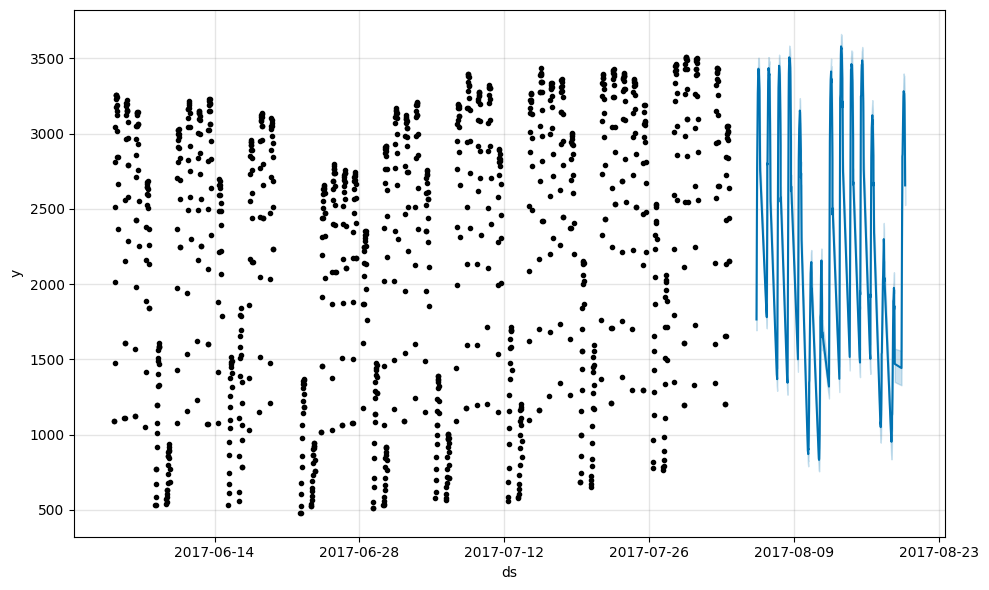

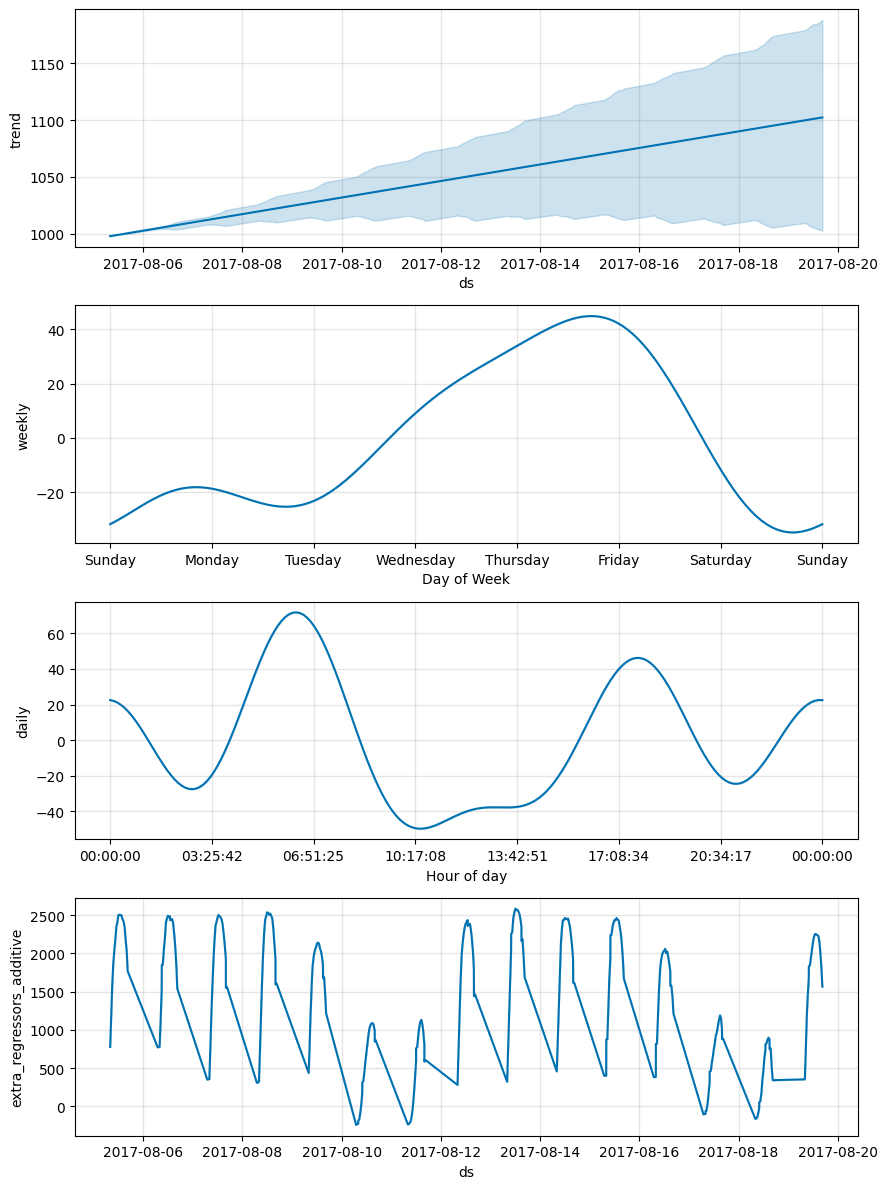

In [17]:
# predict

# plot forecast
fig = model.plot(forecast)
plt.show()

# plot components
fig = model.plot_components(forecast)
plt.show()

In [18]:
import plotly.graph_objs as go

fig = go.Figure()

# Add training data
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Training'))

# Add testing data
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Testing'))

# Add predicted values
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted'))

# Add upper and lower bounds
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Upper Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='Lower Bound'))

fig.update_layout(title='Forecast vs Actuals', xaxis_title='Date', yaxis_title='Usage')

fig.show()


In [19]:
# evaluate model
y_pred = forecast['yhat'].values
y_true = test['y'].values

print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred)}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true, y_pred)}")

Mean Absolute Error: 60.40682792393591
Mean Squared Error: 4866.1580078770985
Root Mean Squared Error: 69.75785266102375
Mean Absolute Percentage Error: 0.03039729042804601


In [20]:
# feature importance
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
3,month,additive,-3.354684e+01
6,hour,additive,-4.547533e+00
4,dayOfWeek,additive,-2.543680e+00
10,dayOfYear,additive,-6.384768e-01
7,minute,additive,-2.378339e-03
1,date,additive,-7.389777e-15
2,year,additive,1.289804e-01
0,total_capacity,additive,2.489444e-01
8,second,additive,4.917017e-01
5,day,additive,2.712089e+00
